In [1]:
import json
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from scipy.special import stirling2
import math
from copy import copy

In [2]:
status_codes = {
    1: 'LOADED',
    2: 'OPTIMAL',
    3: 'INFEASIBLE',
    4: 'INF_OR_UNBD',
    5: 'UNBOUNDED',
    6: 'CUTOFF',
    7: 'ITERATION_LIMIT',
    8: 'NODE_LIMIT',
    9: 'TIME_LIMIT',
    10: 'SOLUTION_LIMIT',
    11: 'INTERRUPTED',
    12: 'NUMERIC',
    13: 'SUBOPTIMAL',
    14: 'INPROGRESS',
    15: 'USER_OBJ_LIMIT'
}

In [3]:
rng = np.random.default_rng(643)

# Exact Moments Validation

Optimize reaction rates given exact moment inputs to validate code for moment equations, etc

Exact moments will satisfy semidefinite constraints (although can also check that this is the case) so no need for cutting planes and can simply optimize the base NLP model with reaction rate objectives.

# NLP code

In [4]:
def compute_order(alpha):
    '''Sum of elements of a power.'''
    order = 0
    for alpha_i in alpha:
        order += alpha_i
    return order

def compute_Nd(S, d):
    '''Number of moments of order <= d (S species)'''
    Nd = math.factorial(S + d) // (math.factorial(d) * math.factorial(S))
    return Nd

def compute_powers(S, d):
    '''Compute the Nd powers of order <= d (S species)'''

    # all powers
    powers = [[0 for s in range(S)]]

    # powers of order d = 0
    powers_prev = [[0 for s in range(S)]]

    # for order d = 1, ..., d
    for order in range(1, d + 1):

        # store powers of order d
        powers_current = []

        # for each power of order d - 1
        for alpha in powers_prev:

            # for each index
            for i in range(S):

                # add 1 to power at index
                alpha_new = copy(alpha)
                alpha_new[i] += 1

                # store (avoid repeats)
                if alpha_new not in powers_current:
                    powers_current.append(alpha_new)

        # update d - 1 powers
        powers += powers_current

        # update overall powers
        powers_prev = powers_current

    return powers

def add_powers(*powers, S):
    '''Add powers (lists) of size S.'''
    plus = [0 for i in range(S)]
    for i in range(S):
        for power in powers:
            plus[i] += power[i]
    return plus

def falling_factorial(n, k):
    '''FF(n,k) = n(n-1) ... (n - k + 1).'''
    val = 1
    for i in range(k):
        val *= (n - i)
    return val

def binomial_moment(n, p, l):
    '''For X ~ Bin(n, p) compute E[X^l].'''
    val = 0
    for k in range(l + 1):
        val += falling_factorial(n, k) * stirling2(l, k) * p**k
    return val

In [5]:
def compute_A(alpha, reactions, vrs, db, R, S, d):
    '''
    Moment equation coefficient matrix
    NOTE: must have order of alpha <= d

    Args:
        alpha: moment order for equation (d/dt mu^alpha = 0)
        reactions: list of strings detailing a_r(x) for each reaction r
        vrs: list of lists detailing v_r for each reaction r
        db: largest order a_r(x)
        R: number of reactions
        S: number of species
        d: maximum moment order used (must be >= order(alpha) + db - 1)

    Returns:
        A: (R, Nd) matrix of coefficients
    '''

    if compute_order(alpha) > d - db + 1:
        raise NotImplementedError(f"Maximum moment order {d} too small for moment equation of alpha = {alpha}: involves moments of higher order.")

    xs = sp.symbols([f'x{i}' for i in range(S)])

    # reaction propensity polynomials
    # props = [eval(str_ar) for str_ar in reactions]
    props = [sp.parse_expr(str_ar, {'xs': xs}) for str_ar in reactions]

    # number of moments of order <= d
    Nd = compute_Nd(S, d)

    # get powers of order <= d
    powers = compute_powers(S, d)

    # setup matrix
    A = np.zeros((R, Nd))

    for r, prop in enumerate(props):

        # expand b(x) * ((x + v_r)**alpha - x**alpha)
        term_1 = 1
        term_2 = 1
        for i in range(S):
            term_1 = term_1 * (xs[i] + vrs[r][i])**alpha[i]
            term_2 = term_2 * xs[i]**alpha[i]
        poly = sp.Poly(prop * (term_1 - term_2), xs)

        # loop over terms
        for xs_power, coeff in zip(poly.monoms(), poly.coeffs()):

            # get matrix index
            col = powers.index(list(xs_power))

            # store
            A[r, col] = coeff

    return A

In [93]:
def beta_moment(l, a, b):
    '''For X ~ Beta(a, b) compute E[X^l]'''
    val = 1
    for r in range(l):
        val *= (a + r) / (a + b + r)
    return val

In [94]:
def compute_B(a, b, S, U, d):
    '''
    Capture efficiency moment scaling matrix

    Args:
        a, b: beta capture parameters
        S: number of species
        U: unobserved species indices
        d: maximum moment order used

    Returns:
        B: (Nd, Nd) matrix of coefficients
    '''

    # number of moments of order <= d
    Nd = compute_Nd(S, d)

    # compute powers of order <= d
    powers = compute_powers(S, d)

    # exact beta moments of order <= d
    y_beta = np.zeros(d + 1)
    for l in range(d + 1):
        y_beta[l] = beta_moment(l, a, b)

    # setup matrix
    B = np.zeros((Nd, Nd))

    p = sp.Symbol('p')
    xs = sp.symbols([f'x{i}' for i in range(S)])

    # for each moment power
    for row, alpha in enumerate(powers):

        # setup polynomail
        poly_alpha = 1

        # for each species
        for i in range(S):

            # unobserved: no capture efficiency
            if i in U:
                moment = xs[i]**alpha[i]

            # observed: compute moment expression for E[Xi^alphai] in xi
            else:
                moment = binomial_moment(xs[i], p, alpha[i])
            
            poly = sp.Poly(moment, p, xs[i])

            # multiply
            poly_alpha = poly_alpha * poly

        # loop over terms
        for (beta_power, *xs_power), coeff in zip(poly_alpha.monoms(), poly_alpha.coeffs()):

            # get matrix index
            col = powers.index(xs_power)

            B[row, col] += coeff * y_beta[beta_power]

    return B

In [148]:
def base_model(model, OB_bounds, a, b, reactions, vrs, db, R, S, U, d, constraints, fixed=[], time_limit=300, K=100):
    '''
    Construct 'base model' with semidefinite constraints removed to give NLP

    Args:
        opt: Optimization class (or subclass), see relevant attributes
        model: empty gurobi model object
        OB_bounds: confidence intervals on observed moments up to order d (at least)

        Relevant class attributes

        a, b: beta capture parameters
        reactions: list of strings detailing a_r(x) for each reaction r
        vrs: list of lists detailing v_r for each reaction r
        db: largest order a_r(x)
        R: number of reactions
        S: number of species
        U: indices of unobserved species
        d: maximum moment order used
        fixed: list of pairs of (reaction index r, value to fix k_r to)
        time_limit: optimization time limit

        constraint options

        moment_bounds: CI bounds on moments
        moment_matrices: 
        moment_equations
        factorization
        factorization_telegraph
        telegraph_moments

    Returns:
        model: gurobi model object with NLP constraints (all but semidefinite)
        variables: dict for model variable reference
    '''

    # model settings
    model.Params.TimeLimit = time_limit

    # helpful values
    Nd = compute_Nd(S, d)

    # variables
    y = model.addMVar(shape=Nd, vtype=GRB.CONTINUOUS, name="y", lb=0)
    k = model.addMVar(shape=R, vtype=GRB.CONTINUOUS, name="k", lb=0, ub=K)

    # variable dict
    variables = {
        'y': y,
        'k': k
    }

    '''
    if constraints['moment_matrices']:

        # moment matrices
        for s in range(S + 1):
            M_s = construct_M_s(y, s, S, d)
            variables[f'M_{s}'] = M_s
    '''
            
    # constraints

    if constraints['moment_bounds']:

        '''
        # get CI bounds on OB moments (up to order d)
        y_lb = OB_bounds[0, :]
        y_ub = OB_bounds[1, :]

        # B scaling matrix
        B = compute_B(opt.dataset.beta, opt.S, opt.U, opt.d)

        # moment bounds
        model.addConstr(B @ y <= y_ub, name="y_UB")
        model.addConstr(B @ y >= y_lb, name="y_LB")
        '''

        # Alternate method:
        # do not adjust bounds (in optimization.py)
        # define downsampled moments y_d = B @ y
        # only explicitly bound observed, leave unobserved unbounded
        # avoids issues with e+100 upper bounds on unobserved moments
        # ------------------------------------------------------------

        # B scaling matrix
        B = compute_B(a, b, S, U, d)

        # downsampled moments
        y_D = B @ y

        # bound
        O = [i for i in range(S) if i not in U]
        powers_S = compute_powers(S, d)
        powers_2 = compute_powers(2, d)
        for i, alpha_S in enumerate(powers_S):
            # check if unobserved moment (non-zero power of unobserved species)
            observed = True
            for j, alpha_j in enumerate(alpha_S):
                if (j in U) and (alpha_j > 0):
                    observed = False
            # observed: bound
            if observed:
                alpha_2 = [alpha_S[i] for i in O]
                j = powers_2.index(alpha_2)
                model.addConstr(y_D[i] <= OB_bounds[1, j], name=f"y_{i}_UB")
                model.addConstr(y_D[i] >= OB_bounds[0, j], name=f"y_{i}_LB")

        # -------------------------------------------------------------

    if constraints['moment_equations']:
                   
        # moment equations (order(alpha) <= d - db + 1)
        moment_powers = compute_powers(S, d - db + 1)
        for alpha in moment_powers:
            A_alpha_d = compute_A(alpha, reactions, vrs, db, R, S, d)
            model.addConstr(k.T @ A_alpha_d @ y == 0, name=f"ME_{alpha}_{d}")

    if constraints['factorization']:

        # factorization bounds
        powers = compute_powers(S, d)
        for i, alpha in enumerate(powers):

            # E[X1^a1 X2^a2] = E[X1^a1] E[X2^a2]
            if (alpha[0] > 0) and (alpha[1] > 0):
                j = powers.index([alpha[0], 0])
                l = powers.index([0, alpha[1]])
                model.addConstr(y[i] == y[j] * y[l], name=f"Moment_factorization_{alpha[0]}_({alpha[1]})")

    if constraints['telegraph_factorization']:

        # factorization bounds
        powers = compute_powers(S, d)
        for i, alpha in enumerate(powers):

            # E[X1^a1 X2^a2 G1^a3 G2^a4] = E[X1^a1 G1^a3] E[X2^a2 G2^a4]
            if (alpha[0] > 0) and (alpha[1] > 0):
                j = powers.index([alpha[0], 0, alpha[2], 0])
                l = powers.index([0, alpha[1], 0, alpha[3]])
                model.addConstr(y[i] == y[j] * y[l], name=f"Moment_factorization_{alpha[0], alpha[2]}_({alpha[1], alpha[3]})")

    if constraints['telegraph_moments']:

        # telegraph moment equality (as Gi in {0, 1}, E[Gi^n] = E[Gi] for n > 0, same with cross moments)
        powers = compute_powers(S, d)
        for i, alpha in enumerate(powers):

            # G1, G2 powers > 0: equal to powers of 1
            if (alpha[2] > 0) and (alpha[3] > 0):
                j = powers.index([alpha[0], alpha[1], 1, 1])
                model.addConstr(y[i] == y[j], name="Telegraph_moment_equality_G1_G2")
            
            # G1 power > 0: equal to power of 1
            elif (alpha[2] > 0):
                j = powers.index([alpha[0], alpha[1], 1, alpha[3]])
                model.addConstr(y[i] == y[j], name="Telegraph_moment_equality_G1")

            # G2 power > 0: equal to power of 1
            elif (alpha[3] > 0):
                j = powers.index([alpha[0], alpha[1], alpha[2], 1])
                model.addConstr(y[i] == y[j], name="Telegraph_moment_equality_G2")

    if constraints['telegraph_moments_ineq']:

        # telegraph moment inequality (as Gi in {0, 1}, E[... Gi] <= E[...])
        powers = compute_powers(S, d)
        for alpha_1 in range(d + 1):
            for alpha_2 in range(d - alpha_1 + 1):

                # E[... G1 G2] <= E[... G1]
                try:
                    i = powers.index([alpha_1, alpha_2, 1, 1])
                    j = powers.index([alpha_1, alpha_2, 1, 0])
                    model.addConstr(y[i] <= y[j], name="Telegraph_moment_inequality_G1G2_G1")
                except ValueError:
                    pass

                # E[... G1 G2] <= E[... G2]
                try:
                    i = powers.index([alpha_1, alpha_2, 1, 1])
                    r = powers.index([alpha_1, alpha_2, 0, 1])
                    model.addConstr(y[i] <= y[r], name="Telegraph_moment_inequality_G1G2_G2")
                except ValueError:
                    pass

                # E[... G1] <= E[...]
                try:
                    j = powers.index([alpha_1, alpha_2, 1, 0])
                    s = powers.index([alpha_1, alpha_2, 0, 0])
                    model.addConstr(y[j] <= y[s], name="Telegraph_moment_inequality_G1")
                except ValueError:
                    pass

                # E[... G2] <= E[...]
                try:
                    r = powers.index([alpha_1, alpha_2, 0, 1])
                    s = powers.index([alpha_1, alpha_2, 0, 0])
                    model.addConstr(y[r] <= y[s], name="Telegraph_moment_inequality_G2")
                except ValueError:
                    pass

    # fixed moment
    model.addConstr(y[0] == 1, name="y0_base")

    # fixed parameters
    for r, val in fixed:
        model.addConstr(k[r] == val, name=f"k{r}_fixed")

    return model, variables

# Exact poisson moment computation

In [10]:
def poisson_moment(l, lam):
    '''For X ~ Poi(lam) compute E[X^l]'''
    if l == 0:
        return 1
    val = 0
    for k in range(1, l + 1):
        val += stirling2(l, k) * lam ** k
    return val

In [11]:
d = 2
k_tx_1 = 2
k_tx_2 = 2
k_deg_1 = 1
k_deg_2 = 1
delta = 0.001

powers = compute_powers(S=2, d=d)
Nd = compute_Nd(S=2, d=d)
moment_bounds = np.zeros((2, Nd))
for i, alpha in enumerate(powers):
    m1 = poisson_moment(alpha[0], k_tx_1 / k_deg_1)
    m2 = poisson_moment(alpha[1], k_tx_2 / k_deg_2)
    moment = m1 * m2
    moment_bounds[:, i] = [moment - delta, moment + delta]

moment_bounds

array([[0.999, 1.999, 1.999, 5.999, 3.999, 5.999],
       [1.001, 2.001, 2.001, 6.001, 4.001, 6.001]])

# Optimize rates under exact poisson moment values

In [41]:
def compute_poisson_moments(params, d, delta):

    powers = compute_powers(S=2, d=d)
    Nd = compute_Nd(S=2, d=d)
    moment_bounds = np.zeros((2, Nd))
    for i, alpha in enumerate(powers):
        m1 = poisson_moment(alpha[0], params['k_tx_1'] / params['k_deg_1'])
        m2 = poisson_moment(alpha[1], params['k_tx_2'] / params['k_deg_2'])
        moment = m1 * m2
        moment_bounds[:, i] = [moment - delta, moment + delta]

    return moment_bounds

In [96]:
# parameters
params = {
    'k_tx_1': 2,
    'k_tx_2': 2,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 0
}

# settings
reactions = [
    "1",
    "xs[0]",
    "1",
    "xs[1]",
    "xs[0] * xs[1]"
]
vrs = [
    [1, 0],
    [-1, 0],
    [0, 1],
    [0, -1],
    [-1, -1]
]
db = 2
R = 5
S = 2
U = []
fixed = [(1, 1), (3, 2), (4, 0)]
d = 6
delta = 0.001
silent = True

# constraints
constraints = {
    'moment_bounds':           True,
    'moment_matrices':         False,
    'moment_equations':        True,
    'factorization':           True,
    'telegraph_factorization': False,
    'telegraph_moments':       False,
    'telegraph_moments_ineq':  False
}

# compute moments
OB_bounds = compute_poisson_moments(params, d, delta)
a, b = 1, 0

# silence output
environment_parameters = {}
if silent:
    environment_parameters['OutputFlag'] = 0

# environment context
with gp.Env(params=environment_parameters) as env:

    # model context
    with gp.Model('test-SDP', env=env) as model:

        # construct model
        model, variables = base_model(model, OB_bounds, a, b, reactions, vrs, db, R, S, U, d, constraints, fixed=fixed, time_limit=300, K=100)

        # optimize reaction rates
        names = ['k_tx_1', 'k_deg_1', 'k_tx_2', 'k_deg_2', 'k_reg']
        solution = {}
        for i, rate in enumerate(variables['k']):

            try:
                model.setObjective(rate, GRB.MINIMIZE)
                model.optimize()
                min_val = model.ObjVal
                min_status = status_codes[model.status]
            except:
                min_val, min_status = None, None

            try:
                model.setObjective(rate, GRB.MAXIMIZE)
                model.optimize()
                max_val = model.ObjVal
                max_status = status_codes[model.status]
            except:
                max_val, max_status = None, None

            solution[names[i]] = [min_val, max_val, min_status, max_status]

            print(f"{names[i]} = {params[names[i]]} bounded in ({min_val}, {max_val}) status ({min_status}, {max_status})")

k_tx_1 = 2 bounded in (1.9999990657306659, 1.9999990657306659) status (OPTIMAL, OPTIMAL)
k_deg_1 = 1 bounded in (1.0, 1.0) status (OPTIMAL, OPTIMAL)
k_tx_2 = 2 bounded in (4.000001864911262, 4.000001864911262) status (OPTIMAL, OPTIMAL)
k_deg_2 = 1 bounded in (2.0, 2.0) status (OPTIMAL, OPTIMAL)
k_reg = 0 bounded in (0.0, -0.0) status (OPTIMAL, OPTIMAL)


## Results

independent birth-death NLP with moment equations, moment bounds (exact values) & moment factorization
- fixing k_deg_1 = k_deg_2 = 1, k_reg = 0 can optimize for exact reaction rates values of k_tx_1, k_tx_2
- valid to fix both degradation rates, as can only find relative values e.g. for true values of k_tx_2 = 2, k_deg_2 = 1, fixing k_deg_2 = 2 gives k_tx_2 = 4

# Exact moments satisfy Moment Matrices

Check that the exact moments produce semidefinite moment matrices

In [14]:
def construct_M_s(y, s, S, d):
    '''Moment matrix variable constructor (s).'''
    if s == 0:
        D = math.floor(d / 2)
    else:
        D = math.floor((d - 1) / 2)
    powers_D = compute_powers(S, D)
    powers_d = compute_powers(S, d)
    ND = compute_Nd(S, D)
    M_s = [[0 for j in range(ND)] for i in range(ND)]
    e_s = [1 if i == (s - 1) else 0 for i in range(S)]
    for alpha_index, alpha in enumerate(powers_D):
        for beta_index, beta in enumerate(powers_D):
            plus = add_powers(alpha, beta, e_s, S=S)
            plus_index = powers_d.index(plus)
            M_s[alpha_index][beta_index] = y[plus_index].item()
    M_s = np.array(M_s) #gp.MVar.fromlist(M_s)
    return M_s

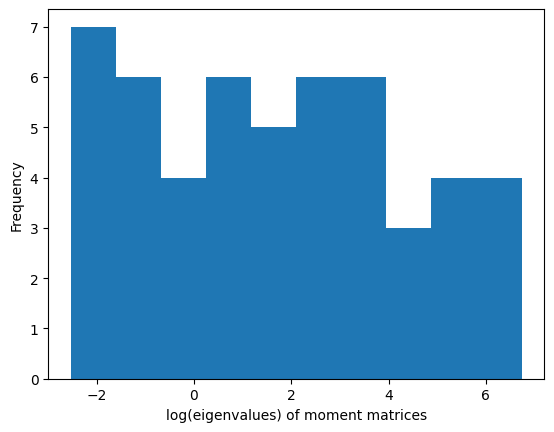

In [38]:
# parameters
S = 2
d = 10
k_tx_1 = 2
k_tx_2 = 2
k_deg_1 = 1
k_deg_2 = 1
eval_eps = 10**(-6)

# compute exact moments
powers = compute_powers(S=2, d=d)
Nd = compute_Nd(S=2, d=d)
moment_values = np.zeros(Nd)
for i, alpha in enumerate(powers):
    m1 = poisson_moment(alpha[0], k_tx_1 / k_deg_1)
    m2 = poisson_moment(alpha[1], k_tx_2 / k_deg_2)
    moment_values[i] = m1 * m2

# compute moment matrices & eigen information at exact moment values
evalues = []
for s in range(S + 1):
    M_s = construct_M_s(moment_values, s, S, d)
    #print(f"M_{s} \n{M_s}\n")
    evals_s, evecs_s = np.linalg.eigh(M_s)
    if not (evals_s >= -eval_eps).all():
         print("Negative eigenvalue")
    else:
        for lam in evals_s:
            evalues.append(np.log10(float(lam)))

# display
plt.hist(evalues)
plt.xlabel("log(eigenvalues) of moment matrices")
plt.ylabel("Frequency")
plt.show()

## Results

- all moment matrices are semidefinite when computed at exact moment values

# Exact beta-poisson moment computation

In [91]:
def beta_moment(l, a, b):
    '''For X ~ Beta(a, b) compute E[X^l]'''
    val = 1
    for r in range(l):
        val *= (a + r) / (a + b + r)
    return val

def beta_poisson_moment(l, lam, a, b):
    '''For X|Y ~ Poi(lam * Y), Y ~ Beta(a, b) compute E[X^l]'''
    if l == 0:
        return 1
    val = 0
    for k in range(1, l + 1):
        val += stirling2(l, k) * (lam ** k) * beta_moment(k, a, b)
    return val

# Optimize rates under exact beta-poisson moment values

In [78]:
def compute_beta_poisson_moments(params, d, delta):

    powers = compute_powers(S=2, d=d)
    Nd = compute_Nd(S=2, d=d)
    moment_bounds = np.zeros((2, Nd))
    for i, alpha in enumerate(powers):
        m1 = beta_poisson_moment(alpha[0], params['k_tx_1'] / params['k_deg_1'], params['k_on_1'] / params['k_deg_1'], params['k_off_1'] / params['k_deg_1'])
        m2 = beta_poisson_moment(alpha[1], params['k_tx_2'] / params['k_deg_2'], params['k_on_2'] / params['k_deg_2'], params['k_off_2'] / params['k_deg_2'])
        moment = m1 * m2
        moment_bounds[:, i] = [moment - delta, moment + delta]

    return moment_bounds

In [97]:
# parameters
params = {
    'k_on_1': 1,
    'k_on_2': 1,
    'k_off_1': 1,
    'k_off_2': 1,
    'k_tx_1': 2,
    'k_tx_2': 2,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 0
}

# settings
reactions = [
    "1 - xs[2]",
    "xs[2]",
    "xs[2]",
    "xs[0]",
    "1 - xs[3]",
    "xs[3]",
    "xs[3]",
    "xs[1]",
    "xs[0] * xs[1]"
]
vrs = [
    [0, 0, 1, 0],
    [0, 0, -1, 0],
    [1, 0, 0, 0],
    [-1, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 0, -1],
    [0, 1, 0, 0],
    [0, -1, 0, 0],
    [-1, -1, 0, 0]
]
db = 2
R = 9
S = 4
U = [2, 3]
fixed = [(3, 1), (7, 1), (8, 0)]
d = 6
delta = 0.001
silent = True

# constraints
constraints = {
    'moment_bounds':           True,
    'moment_matrices':         False,
    'moment_equations':        True,
    'factorization':           False,
    'telegraph_factorization': True,
    'telegraph_moments':       True,
    'telegraph_moments_ineq':  True
}

# compute moments
OB_bounds = compute_beta_poisson_moments(params, d, delta)
a, b = 1, 0

# silence output
environment_parameters = {}
if silent:
    environment_parameters['OutputFlag'] = 0

# environment context
with gp.Env(params=environment_parameters) as env:

    # model context
    with gp.Model('test-SDP', env=env) as model:

        # construct model
        model, variables = base_model(model, OB_bounds, a, b, reactions, vrs, db, R, S, U, d, constraints, fixed=fixed, time_limit=300, K=100)

        # optimize reaction rates
        names = ['k_on_1', 'k_off_1', 'k_tx_1', 'k_deg_1', 'k_on_2', 'k_off_2', 'k_tx_2', 'k_deg_2', 'k_reg']
        solution = {}
        for i, rate in enumerate(variables['k']):

            try:
                model.setObjective(rate, GRB.MINIMIZE)
                model.optimize()
                min_val = model.ObjVal
                min_status = status_codes[model.status]
            except:
                min_val, min_status = None, None

            try:
                model.setObjective(rate, GRB.MAXIMIZE)
                model.optimize()
                max_val = model.ObjVal
                max_status = status_codes[model.status]
            except:
                max_val, max_status = None, None

            solution[names[i]] = [min_val, max_val, min_status, max_status]

            print(f"{names[i]} = {params[names[i]]} bounded in ({min_val}, {max_val}) status ({min_status}, {max_status})")

k_on_1 = 1 bounded in (0.9977658352818548, 1.0022413731143835) status (OPTIMAL, OPTIMAL)
k_off_1 = 1 bounded in (0.9961916680024419, 1.0038105791169873) status (OPTIMAL, OPTIMAL)
k_tx_1 = 2 bounded in (1.99841230922176, 2.001549037835443) status (OPTIMAL, OPTIMAL)
k_deg_1 = 1 bounded in (1.0, 1.0) status (OPTIMAL, OPTIMAL)
k_on_2 = 1 bounded in (0.997761733609004, 1.0022517423278072) status (OPTIMAL, OPTIMAL)
k_off_2 = 1 bounded in (0.996264729030669, 1.0037768198401953) status (OPTIMAL, OPTIMAL)
k_tx_2 = 2 bounded in (1.9984264844675226, 2.001601484655494) status (OPTIMAL, OPTIMAL)
k_deg_2 = 1 bounded in (1.0, 1.0) status (OPTIMAL, OPTIMAL)
k_reg = 0 bounded in (0.0, -0.0) status (OPTIMAL, OPTIMAL)


## Results

independent telegraph NLP with moment equations, moment bounds (exact values) & moment factorization + moment (in)equalities
- fixing k_deg_1 = k_deg_2 = 1, k_reg = 0 can optimize for exact reaction rates values of k_on, k_off, k_tx 1 & 2

# Capture efficiency

Poisson under beta distributed capture efficiency is beta-poisson so can use telegraph code to try

In [149]:
def compute_capture_moments(a, b, params, d, delta):

    powers = compute_powers(S=2, d=d)
    Nd = compute_Nd(S=2, d=d)
    moment_bounds = np.zeros((2, Nd))
    for i, alpha in enumerate(powers):
        m1 = beta_poisson_moment(alpha[0], params['k_tx_1'] / params['k_deg_1'], a, b)
        m2 = beta_poisson_moment(alpha[1], params['k_tx_2'] / params['k_deg_2'], a, b)
        moment = m1 * m2
        moment_bounds[:, i] = [moment - delta, moment + delta]

    return moment_bounds

In [150]:
# parameters
params = {
    'k_tx_1': 2,
    'k_tx_2': 2,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 0
}

# settings
reactions = [
    "1",
    "xs[0]",
    "1",
    "xs[1]",
    "xs[0] * xs[1]"
]
vrs = [
    [1, 0],
    [-1, 0],
    [0, 1],
    [0, -1],
    [-1, -1]
]
db = 2
R = 5
S = 2
U = []
fixed = [(1, 1), (4, 0)] #[(1, 1), (3, 1), (4, 0)]
d = 4
delta = 0.01
silent = True

# constraints
constraints = {
    'moment_bounds':           True,
    'moment_matrices':         False,
    'moment_equations':        True,
    'factorization':           False,
    'telegraph_factorization': False,
    'telegraph_moments':       False,
    'telegraph_moments_ineq':  False
}

# compute moments
a, b = 1, 1
OB_bounds = compute_capture_moments(a, b, params, d, delta)

# silence output
environment_parameters = {}
if silent:
    environment_parameters['OutputFlag'] = 0

# environment context
with gp.Env(params=environment_parameters) as env:

    # model context
    with gp.Model('test-SDP', env=env) as model:

        # construct model
        model, variables = base_model(model, OB_bounds, a, b, reactions, vrs, db, R, S, U, d, constraints, fixed=fixed, time_limit=300, K=100)

        # optimize reaction rates
        names = ['k_tx_1', 'k_deg_1', 'k_tx_2', 'k_deg_2', 'k_reg']
        solution = {}
        for i, rate in enumerate(variables['k']):

            try:
                model.setObjective(rate, GRB.MINIMIZE)
                model.optimize()
                min_val = model.ObjVal
                min_status = status_codes[model.status]
            except:
                min_val, min_status = None, None

            try:
                model.setObjective(rate, GRB.MAXIMIZE)
                model.optimize()
                max_val = model.ObjVal
                max_status = status_codes[model.status]
            except:
                max_val, max_status = None, None

            solution[names[i]] = [min_val, max_val, min_status, max_status]

            print(f"{names[i]} = {params[names[i]]} bounded in ({min_val}, {max_val}) status ({min_status}, {max_status})")

k_tx_1 = 2 bounded in (None, None) status (None, None)
k_deg_1 = 1 bounded in (None, None) status (None, None)
k_tx_2 = 2 bounded in (None, None) status (None, None)
k_deg_2 = 1 bounded in (None, None) status (None, None)
k_reg = 0 bounded in (None, None) status (None, None)


## Results

- infeasible when using factorization constraints, d > 2, or delta < 0.1
- either bug in logic or B matrix
- a, b = 1, 0 works perfectly (100% capture case)

### TODO
- check B @ y' = y for exact moments y and y'

In [160]:
def compute_est_B(beta, S, U, d):
    '''
    Capture efficiency moment scaling matrix

    Args:
        beta: per cell capture efficiency sample
        S: number of species
        U: unobserved species indices
        d: maximum moment order used

    Returns:
        B: (Nd, Nd) matrix of coefficients
    '''

    # number of moments of order <= d
    Nd = compute_Nd(S, d)

    # compute powers of order <= d
    powers = compute_powers(S, d)

    # compute beta moments of order <= d
    y_beta = np.zeros(d + 1)
    for l in range(d + 1):
        y_beta[l] = np.mean(beta**l)

    # setup matrix
    B = np.zeros((Nd, Nd))

    p = sp.Symbol('p')
    xs = sp.symbols([f'x{i}' for i in range(S)])

    # for each moment power
    for row, alpha in enumerate(powers):

        # setup polynomail
        poly_alpha = 1

        # for each species
        for i in range(S):

            # unobserved: no capture efficiency
            if i in U:
                moment = xs[i]**alpha[i]

            # observed: compute moment expression for E[Xi^alphai] in xi
            else:
                moment = binomial_moment(xs[i], p, alpha[i])
            
            poly = sp.Poly(moment, p, xs[i])

            # multiply
            poly_alpha = poly_alpha * poly

        # loop over terms
        for (beta_power, *xs_power), coeff in zip(poly_alpha.monoms(), poly_alpha.coeffs()):

            # get matrix index
            col = powers.index(xs_power)

            B[row, col] += coeff * y_beta[beta_power]

    return B

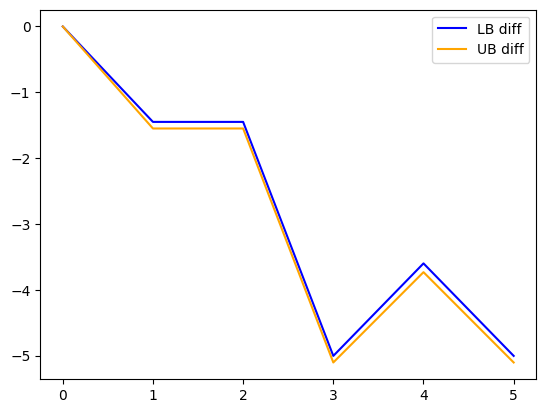

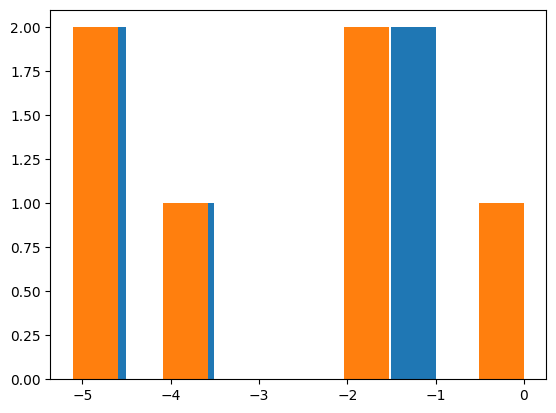

In [165]:
# parameters
params = {
    'k_tx_1': 2,
    'k_tx_2': 2,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 0
}

# settings
S = 2
U = []
delta = 0.1
d = 2
a, b = 1, 1

# exact downsampled moments
y_D = compute_capture_moments(a, b, params, d, delta)

# exact original moments
y = compute_poisson_moments(params, d, delta)

# exact capture scaling matrix
B = compute_B(a, b, S, U, d)

#beta = rng.beta(a, b, size=1000)
#B = compute_est_B(beta, S, U, d)

y_scaled_lb = B @ y_D[0, :]
y_scaled_ub = B @ y_D[1, :]

plt.plot(y_scaled_lb - y[0, :], color="blue", label="LB diff")
plt.plot(y_scaled_ub - y[1, :], color="orange", label="UB diff")
plt.legend()
plt.show()

plt.hist(y_scaled_lb - y[0, :])
plt.hist(y_scaled_ub - y[1, :])
plt.show()

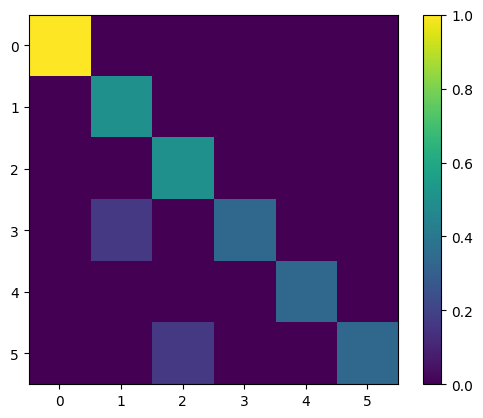

In [170]:
plt.imshow(B)
plt.colorbar(cmap='plasma')